In [1]:
import os
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchmetrics import Accuracy,F1Score
import random
from timeit import default_timer as timer

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
data_path = Path("data/")
data_path.mkdir(parents=True,exist_ok=True)

In [ ]:
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df = pd.DataFrame(image_list)

In [ ]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,Full Water level
1,data\Full Water level\Full Water level\01-wa...,Full Water level
2,data\Full Water level\Full Water level\0bnC0...,Full Water level
3,data\Full Water level\Full Water level\1-0l-...,Full Water level
4,data\Full Water level\Full Water level\1000_...,Full Water level


In [ ]:
df.shape

(429, 2)

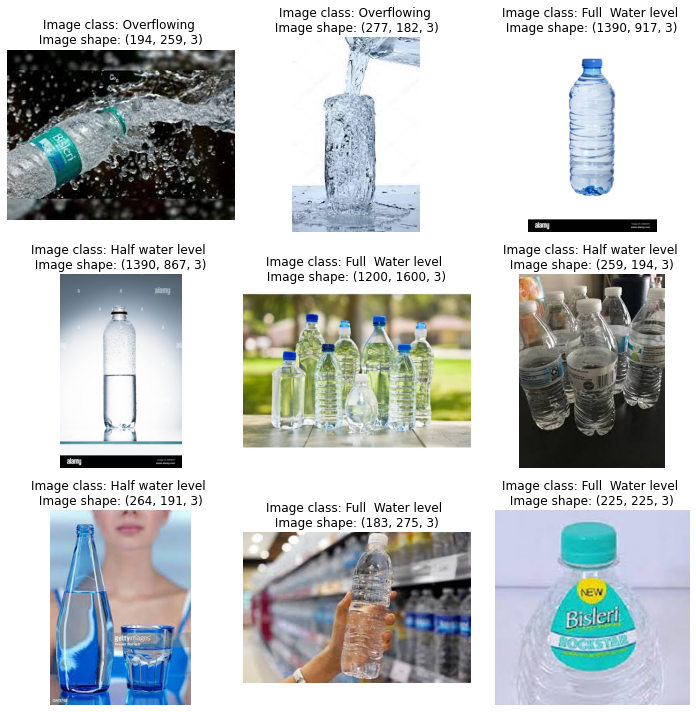

In [ ]:
def plot_image(data):

    rnd_sample = df.sample(9)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, path in zip(axes, rnd_sample["path"]):
        img_class = rnd_sample[rnd_sample["path"] == path]["classes"].iloc[0]

        img = Image.open(path)
        img_as_array = np.array(img)
        ax.imshow(img_as_array)
        ax.set_title(f"Image class: {img_class} \n Image shape: {img_as_array.shape} ")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_image(df)


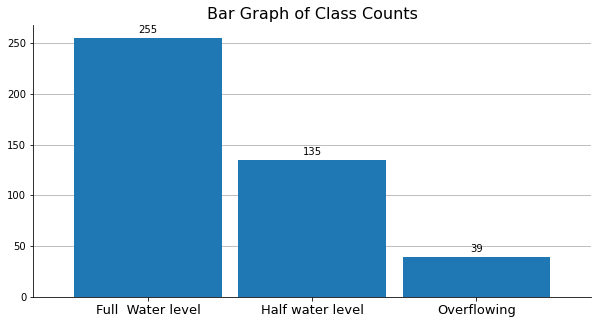

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Bar Graph of Class Counts", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")


#### We have imbalanced label.

In [ ]:
df["classes"] = df["classes"].map(
    {
        "Full  Water level": "full",
        "Half water level": "half",
        "Overflowing": "overflowing",
    }
)


In [ ]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,full
1,data\Full Water level\Full Water level\01-wa...,full
2,data\Full Water level\Full Water level\0bnC0...,full
3,data\Full Water level\Full Water level\1-0l-...,full
4,data\Full Water level\Full Water level\1000_...,full


In [ ]:
from sklearn.model_selection import train_test_split


train_df,test_df = train_test_split(df,test_size=0.2,shuffle=True,random_state=42)

In [ ]:
train_df.shape,test_df.shape

((343, 2), (86, 2))

In [ ]:
def find_classes(data):
    # Get the class names by scanning the target directory
    classes = ["full", "half", "overflowing"]
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx


In [ ]:
find_classes(df)

(['full', 'half', 'overflowing'], {'full': 0, 'half': 1, 'overflowing': 2})

In [ ]:
class CustomImageFolder(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(data)
        self.targets = data.classes.values

    def __len__(self):
        return len(self.data)

    def load_image(self, idx: int) -> Image.Image:
        image_path = self.data.iloc[idx, 0]
        return Image.open(image_path)

    def __getitem__(self, idx):

        img = self.load_image(idx)

        class_name = self.data.iloc[idx, 1]
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx

        else:
            return img, class_idx


In [ ]:
from torchvision import datasets

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
])
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
])


In [ ]:
train_data_transformed = CustomImageFolder(train_df, transform=train_transform)
test_data_transformed = CustomImageFolder(test_df, transform=test_transform)

In [ ]:
class_names=train_data_transformed.classes

### Random image in train dataset

In [ ]:
def visualize_random_images(data, classes, num_images=3):
    random_samples_idx = random.sample(range(len(data)), k=num_images)
    plt.figure(figsize=(10, 10))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = (
            data[targ_sample][0],
            data[targ_sample][1],
        )
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")

        title = f"class: {classes[targ_label]}"

        title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


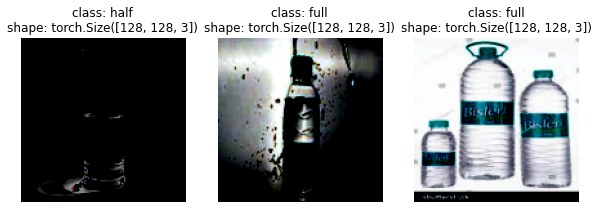

In [ ]:
visualize_random_images(train_data_transformed,class_names)

### Random image in test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


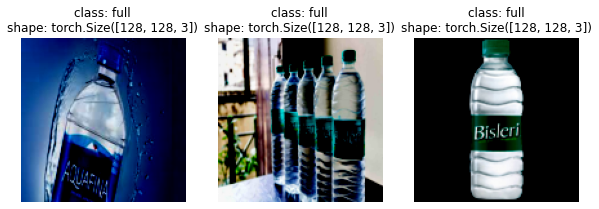

In [ ]:
visualize_random_images(test_data_transformed,class_names)

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data_transformed, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data_transformed, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
img_batch, label_batch = next(iter(train_dataloader))
print(f"Image Shape: {img_batch.shape} -> [batch_size,color_channels,height,width]")
print(f"Label shape: {label_batch.shape}")


Image Shape: torch.Size([32, 3, 128, 128]) -> [batch_size,color_channels,height,width]
Label shape: torch.Size([32])


## Creating Baseline Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import torch
from torch import nn

In [ ]:
from torchinfo import summary

In [ ]:
class WaterBottleModel(nn.Module):
    def __init__(self,input_shape:int,output_shape:int,hidden_units:int):
        super().__init__()
        self.layer_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=53824,out_features=output_shape)

        )
            
        
    def forward(self,x):
        
        return  self.clf(self.layer_block_2(self.layer_block_1(x)))

model = WaterBottleModel(input_shape=3,output_shape=3,hidden_units=32).to(device)  # input shape = 64x64x3


In [ ]:
summary(model, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
WaterBottleModel                         [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 62, 62]          --
│    └─Conv2d: 2-1                       [32, 64, 126, 126]        1,792
│    └─ReLU: 2-2                         [32, 64, 126, 126]        --
│    └─Conv2d: 2-3                       [32, 64, 124, 124]        36,928
│    └─ReLU: 2-4                         [32, 64, 124, 124]        --
│    └─MaxPool2d: 2-5                    [32, 64, 62, 62]          --
├─Sequential: 1-2                        [32, 64, 29, 29]          --
│    └─Conv2d: 2-6                       [32, 64, 60, 60]          36,928
│    └─ReLU: 2-7                         [32, 64, 60, 60]          --
│    └─Conv2d: 2-8                       [32, 64, 58, 58]          36,928
│    └─ReLU: 2-9                         [32, 64, 58, 58]          --
│    └─MaxPool2d: 2-10                   [32, 64, 29, 29]          --


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights=compute_class_weight(class_weight="balanced",classes=train_data_transformed.classes,y=train_data_transformed.targets)
class_weights=torch.tensor(class_weights,dtype=torch.float,device=device)

In [ ]:
#class_weights tensor([0.5688, 1.0208, 3.8111], device='cuda:0')

In [ ]:
class_weights

tensor([0.5688, 1.0208, 3.8111], device='cuda:0')

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.0001)
accuracy_fn = Accuracy(task="multiclass",num_classes=len(train_data_transformed.classes)).to(device)
f1_score_fn = F1Score(task="multiclass",num_classes=len(train_data_transformed.classes),average="macro").to(device)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def train_step(model,dataloader,loss_fn,optimizer,accuracy_fn,f1_score,device):
    
    model.train()
    train_loss,train_acc,train_f1_score=0,0,0

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred,y)
        train_f1_score += f1_score(y_pred,y)
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_f1_score /= len(dataloader)

    return train_loss,train_acc,train_f1_score

In [ ]:
def test_step(model,dataloader,loss_fn,accuracy_fn,f1_score,device):
    model.eval()
    test_loss, test_acc,test_f1_score =0,0,0
    
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss
            test_acc += accuracy_fn(y_pred,y)
            test_f1_score += f1_score(y_pred,y)
            
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        test_f1_score /= len(dataloader)
        

    return test_loss,test_acc,test_f1_score

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def train(model,train_dataloader,test_dataloader,loss_fn,optimizer,epochs,device):
    results= {"train_loss": [],
            "train_acc":[],
            "train_f1_score":[],
            "test_loss":[],
            "test_acc":[],
            "test_f1_score":[]}

    for epoch in tqdm(range(epochs)):

        train_loss,train_acc,train_f1_score = train_step(model,train_dataloader,loss_fn,optimizer,accuracy_fn,f1_score_fn,device)
        test_loss,test_acc,test_f1_score= test_step(model,test_dataloader,loss_fn,accuracy_fn,f1_score_fn,device)

        if epoch % 10 == 0:

            print(
            f"Epoch: {epoch} \n "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {np.round(train_acc.item(),4)*100}% | "
            f"train_f1_score: {np.round(train_f1_score.item(),4)*100}% | \n "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {np.round(test_acc.item(),2)*100}% | "
            f"test_f1_score: {np.round(test_f1_score.item(),2)*100}%"
            )

        
        results["train_loss"].append(train_loss.cpu().detach().numpy())
        results["train_acc"].append(train_acc.cpu().detach().numpy())
        results["train_f1_score"].append(train_f1_score.cpu().detach().numpy())
        results["test_loss"].append(test_loss.cpu().detach().numpy())
        results["test_acc"].append(test_acc.cpu().detach().numpy())
        results["test_f1_score"].append(test_f1_score.cpu().detach().numpy())

    
    return results

In [ ]:
# Train model_0 
start_time = timer()
NUM_EPOCHS = 100
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print("Train time: ", end_time - start_time)

  1%|          | 1/100 [00:16<27:47, 16.84s/it]

Epoch: 0 
 train_loss: 0.9415 | train_acc: 54.85% | train_f1_score: 23.41% | 
 test_loss: 0.8935 | test_acc: 63.0% | test_f1_score: 26.0%


 11%|█         | 11/100 [03:04<24:58, 16.84s/it]

Epoch: 10 
 train_loss: 0.7579 | train_acc: 67.69% | train_f1_score: 43.55% | 
 test_loss: 0.7164 | test_acc: 67.0% | test_f1_score: 43.0%


 21%|██        | 21/100 [05:50<21:19, 16.19s/it]

Epoch: 20 
 train_loss: 0.6105 | train_acc: 76.14999999999999% | train_f1_score: 61.040000000000006% | 
 test_loss: 0.7089 | test_acc: 67.0% | test_f1_score: 43.0%


 31%|███       | 31/100 [08:38<19:13, 16.72s/it]

Epoch: 30 
 train_loss: 0.5783 | train_acc: 76.42999999999999% | train_f1_score: 61.150000000000006% | 
 test_loss: 0.7374 | test_acc: 69.0% | test_f1_score: 46.0%


 41%|████      | 41/100 [11:26<16:31, 16.81s/it]

Epoch: 40 
 train_loss: 0.4515 | train_acc: 83.93% | train_f1_score: 75.8% | 
 test_loss: 0.8828 | test_acc: 72.0% | test_f1_score: 52.0%


 51%|█████     | 51/100 [14:17<13:54, 17.02s/it]

Epoch: 50 
 train_loss: 0.4118 | train_acc: 84.67% | train_f1_score: 77.66% | 
 test_loss: 0.8431 | test_acc: 75.0% | test_f1_score: 61.0%


 61%|██████    | 61/100 [17:04<11:14, 17.29s/it]

Epoch: 60 
 train_loss: 0.3197 | train_acc: 89.16% | train_f1_score: 84.66% | 
 test_loss: 0.9382 | test_acc: 73.0% | test_f1_score: 60.0%


 71%|███████   | 71/100 [19:45<07:53, 16.33s/it]

Epoch: 70 
 train_loss: 0.3516 | train_acc: 88.41% | train_f1_score: 82.54% | 
 test_loss: 0.9618 | test_acc: 72.0% | test_f1_score: 56.99999999999999%


 81%|████████  | 81/100 [22:32<05:21, 16.94s/it]

Epoch: 80 
 train_loss: 0.2665 | train_acc: 90.42% | train_f1_score: 83.6% | 
 test_loss: 0.9656 | test_acc: 73.0% | test_f1_score: 62.0%


 91%|█████████ | 91/100 [25:22<02:30, 16.72s/it]

Epoch: 90 
 train_loss: 0.1926 | train_acc: 92.74% | train_f1_score: 91.74% | 
 test_loss: 1.0245 | test_acc: 71.0% | test_f1_score: 59.0%


100%|██████████| 100/100 [28:03<00:00, 16.84s/it]

Train time:  1683.5312219


In [ ]:
def plot_curves(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    train_f1_score = results["train_f1_score"]
    test_f1_score = results["test_f1_score"]
    epochs = range(len(train_loss))

    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    fig.suptitle("Comparison of Training and Testing Metrics Over Epochs", fontsize=16)

    metric_names = [("loss", "Loss"), ("acc", "Accuracy"), ("f1_score", "F1 Score")]
    for ax, (metric, label) in zip(axes, metric_names):
        ax.plot(epochs, results[f"train_{metric}"], label=f"train {label}")
        ax.plot(epochs, results[f"test_{metric}"], label=f"test {label}")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(which="both", axis="y")
        ax.set_axisbelow(True)
        ax.set_xlabel("Epochs")
        ax.set_title(label)
        ax.legend()

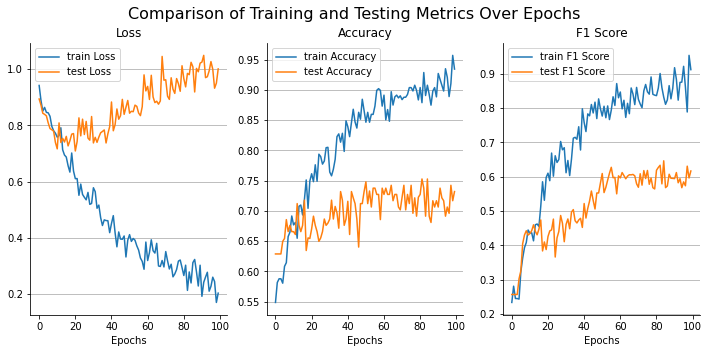

In [ ]:
plot_curves(model_results)

In [ ]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


In [ ]:
targets=test_data_transformed.targets
mapping = {'full': 0, 'half': 1, 'overflowing': 2}
targets = np.array([mapping[i] for i in targets])

In [ ]:
clf_report = classification_report(targets, y_pred_tensor.cpu().numpy(), 
        target_names=train_data_transformed.classes)
print(clf_report)

              precision    recall  f1-score   support

        full       0.81      0.85      0.83        54
        half       0.61      0.61      0.61        23
 overflowing       0.50      0.33      0.40         9

    accuracy                           0.73        86
   macro avg       0.64      0.60      0.61        86
weighted avg       0.72      0.73      0.73        86



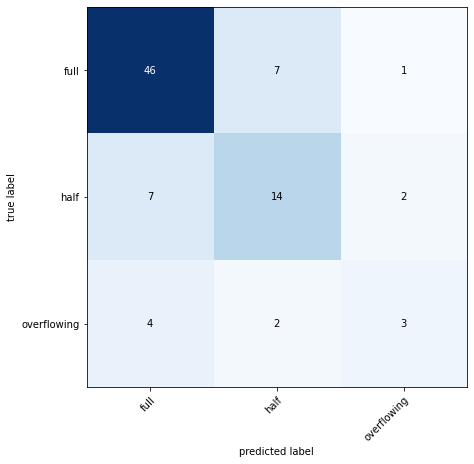

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix


confmat = ConfusionMatrix(num_classes=len(train_data_transformed.classes), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,target=torch.from_numpy(targets).type(torch.float)
                         )

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data_transformed.classes, #
    figsize=(10, 7))